# SARII

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai.basics as fai
import fastai.text as ftxt
import pandas as pd
import numpy as np

In [3]:
import PIL
import textwrap
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

In [5]:
import random
import os
import glob
from google_images_download import google_images_download
import matplotlib.pyplot as plt

## Data

In [6]:
df = pd.read_csv('data/allquotes.csv',header=None, names=['quote', 'author'])
df = df.drop(['author'], axis=1)
df = df.dropna()

In [7]:
df.head()

,quote
0,“Do one thing every day that scares you.”
1,"“We are what we pretend to be, so we must be c..."
2,"“When we love, we always strive to become bett..."
3,“Sometimes you wake up. Sometimes the fall kil...
4,"“Hold fast to dreams,For if dreams dieLife is ..."


In [8]:
df['quote'] = df['quote'].str.lower()

In [9]:
df.head()

,quote
0,“do one thing every day that scares you.”
1,"“we are what we pretend to be, so we must be c..."
2,"“when we love, we always strive to become bett..."
3,“sometimes you wake up. sometimes the fall kil...
4,"“hold fast to dreams,for if dreams dielife is ..."


In [10]:
valid_pct = 0.1 #validation percent
df = df.iloc[np.random.permutation(len(df))]
cut = int(valid_pct * len(df)) + 1
train_df, valid_df = df[cut:], df[:cut]

In [11]:
len(train_df), len(valid_df)

(10883, 1210)

In [12]:
data_lm = ftxt.TextLMDataBunch.from_df('data', train_df, valid_df, text_cols='quote')

## Langueaje Model

In [13]:
learn_lm = ftxt.language_model_learner(data_lm, ftxt.AWD_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


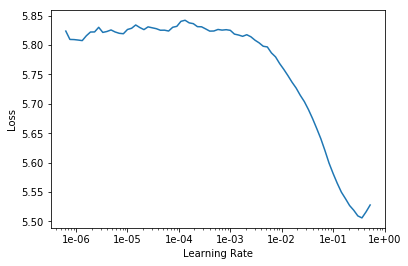

In [14]:
learn_lm.lr_find(); learn_lm.recorder.plot(skip_end=15)

In [15]:
learn_lm.fit_one_cycle(20, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.601491,4.732169,0.216696,00:08
1,5.160850,4.153465,0.262679,00:08
2,4.676903,3.886120,0.301161,00:08
3,4.409472,3.807175,0.306228,00:08
4,4.242657,3.768859,0.308170,00:08
5,4.144249,3.746437,0.309442,00:08
6,4.058526,3.725384,0.313728,00:08
7,3.977828,3.709979,0.314598,00:08
8,3.915846,3.693551,0.316696,00:08
9,3.867001,3.682978,0.318147,00:08


In [16]:
learn_lm.save("lm-31")

In [17]:
learn_lm.save_encoder('lm-31-encoder')

In [18]:
learn_lm.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


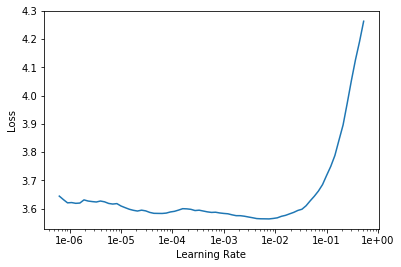

In [19]:
learn_lm.lr_find(); learn_lm.recorder.plot(skip_end=15)

In [20]:
learn_lm.fit_one_cycle(5, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.565772,3.632028,0.328795,00:10
1,3.546981,3.618408,0.330960,00:10
2,3.530112,3.612081,0.331696,00:10
3,3.505076,3.607649,0.331652,00:10
4,3.489362,3.606425,0.332433,00:10


## Validate and Save

In [21]:
learn_lm.validate()

[3.6054502, tensor(0.3329)]

In [22]:
learn_lm.save("lm-final")

In [23]:
learn_lm.save_encoder('lm-encoder')

In [24]:
learn_lm.export()

## Generating Quotes and Images

In [25]:
def generatequote():    
    quotes = []
    while quotes==[]:
        idea = learn_lm.predict("xxbos", n_words=20, temperature=0.75)
        ideas = idea.split("xxbos")
        if ideas[1][-1] == "”":
            quotes.append(ideas[1])
            
    message = quotes[0][:]
    message = '“'+message[3:].capitalize()
    message = message.replace(' . ','.')
    message = message.replace(' ,',',')
    message = message.replace("do n't", "don't")
    message = message.replace("ca n't", "can't")
    message = message.replace("we 're", "we're")
    message = message.replace(" ’s", "’s")
    message = message.replace(" 've", "'ve")
    
    return message

In [26]:
def text2image(imageFile,font,quote):
    
    font = ImageFont.truetype(font, 50)

    para = textwrap.wrap(quote, width=40)

    MAX_W, MAX_H = 1080, 1080

    im = Image.open(imageFile).convert('RGBA')

    im = im.resize((1080, 1080), Image.ANTIALIAS)

    poly = Image.new('RGBA', (1080,1080))
    polydraw = ImageDraw.Draw(poly)

    polydraw.rectangle([(0,0),(1080,1080)], fill=(0,0,0,50), outline=None)
    
    im.paste(poly,mask=poly)

    draw = ImageDraw.Draw(im)

    current_h, pad = 400, 10

    for line in para:
        w, h = draw.textsize(line, font=font)
        draw.text(((MAX_W - w) / 2, current_h), line, font=font)
        current_h += h + pad
    """
    current_h2, pad2 = 900, 80
    currentauthor = authors[idx]
    w, h = draw.textsize(currentauthor, font=authorfont)
    draw.text(((MAX_W - w) / 2, (current_h + 100)), currentauthor, font=authorfont)
    current_h2 += h + pad2
    """
    current_h3, pad3 = 700, 10
    sitelink = "@SARII"
    w, h = draw.textsize(sitelink, font=font)
    draw.text(((MAX_W - w) / 2, current_h3), sitelink, font=font)
    current_h3 += h + pad3

    plt.imshow(np.asarray(im))
    newfilename = "%d.png" %np.random.randint(0,100)
    finalpath = "generated/"+newfilename
    im.save(finalpath)
    return(finalpath)

In [27]:
def downloadimage(key):
    response = google_images_download.googleimagesdownload()   #class instantiation

    key = key +" "+ str(np.random.randint(0,100))

    arguments = {"keywords":key,"limit":1,"print_urls":False,"silent_mode":True,"size":"large","format":"jpg"}   #creating list of arguments
    paths = response.download(arguments)   #passing the arguments to the function
    imagepath=paths[0][key][0]
    
    return imagepath

In [28]:
def selectfont():
    fonts = []
    os.chdir("fonts")
    for file in glob.glob("*.ttf"):
        fonts.append("fonts/"+file)
    os.chdir("..")
    return random.choice(fonts)

Generate text and image

fonts/Champagne & Limousines.ttf


generated/19.png


“The ability to be driven by a steady devotion to your life is not a constant revolution.”




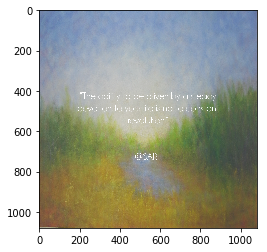

In [30]:
message = generatequote()

imagepath = downloadimage("landscape ")

selectedfont = selectfont()
    
restultimage = text2image(imagepath,selectedfont,message)

print(selectedfont)
print("\n")
print(restultimage)
print("\n")
print(message)
print("\n")
